In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [3]:
Features = pd.read_csv("../utils/features.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [4]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
joblib.dump(encoder,"../utils/encoder.pkl")

['../utils/encoder.pkl']

In [5]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22917, 162), (22917, 8), (7639, 162), (7639, 8))

In [6]:
# scaling our data with sklearn's Standard scaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "../utils/scaler.pkl")
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22917, 162), (22917, 8), (7639, 162), (7639, 8))

In [7]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22917, 162, 1), (22917, 8), (7639, 162, 1), (7639, 8))

In [8]:
model = keras.saving.load_model("../utils/speech_recognition_model.keras")

In [9]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5957 - loss: 1.0901
Accuracy of our model on test data :  59.536588191986084 %


In [10]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [11]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,disgust,disgust
2,sad,sad
3,disgust,disgust
4,happy,angry
5,neutral,disgust
6,disgust,disgust
7,neutral,neutral
8,fear,fear
9,calm,calm


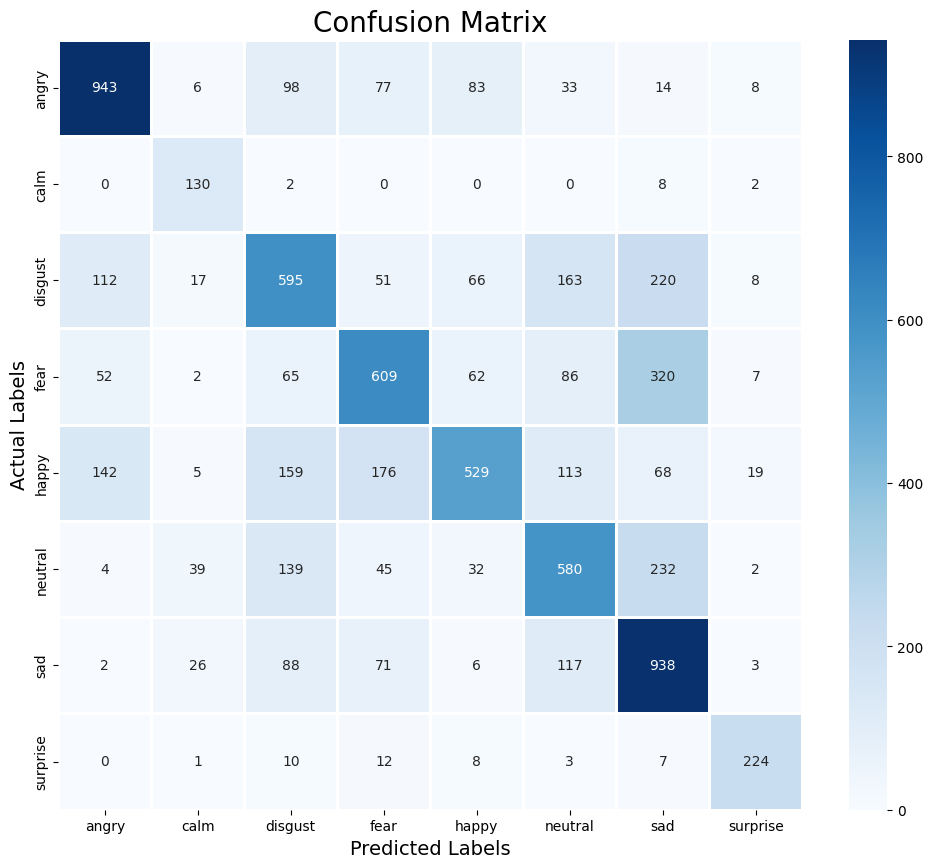

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.75      0.75      1262
        calm       0.58      0.92      0.71       142
     disgust       0.51      0.48      0.50      1232
        fear       0.59      0.51      0.54      1203
       happy       0.67      0.44      0.53      1211
     neutral       0.53      0.54      0.54      1073
         sad       0.52      0.75      0.61      1251
    surprise       0.82      0.85      0.83       265

    accuracy                           0.60      7639
   macro avg       0.62      0.65      0.63      7639
weighted avg       0.60      0.60      0.59      7639



In [14]:
data_path = pd.read_csv("../utils/data_path.csv")

In [15]:
# To make our model to learn and adapt to real-life situations, as noise stimulates the real-life situations
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretching the audio file will include making it fast and slow, allowing our model to detect emotions in both slow and fast speech.
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Time shifting stimulates the start of the audio, allowing our model to learn when the audio starts in an audio file.
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# To help model with high and low pitches
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sr=sampling_rate, n_steps=pitch_factor)

# Taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [16]:
def extract_features(data):
    # ZCR
    # The zero-crossing rate is the rate at which the audio signal changes from positive to negative or vice versa. It gives an idea of how noisy or percussive the signal is.
    # This feature is useful when playing with audios having high disturbance or unvoiced sounds.
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    # This feature is useful for identifying harmonic and pitch-related information, which can help distinguish different emotions in speech (e.g., sadness may have a different harmonic pattern than excitement).
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    # MFCCs are highly effective in speech and emotion recognition because they model how humans perceive sound, focusing on the most important features of speech.
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    # RMS is useful for distinguishing between different speech emotions. For example, speech with higher energy may indicate excitement or anger, while lower energy may indicate calmness or sadness.
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    # The Mel spectrogram captures the timbre and texture of the audio, which can be crucial for recognizing the emotional content of speech. For instance, anger or excitement might have more energy in higher-frequency bands, while sadness might be more present in lower frequencies.
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [17]:
path_ = '../api/audios/audio_to_process.wav'
data_, sample_rate_ = librosa.load(path_)
print(data_.shape)
X_ = np.array(extract_features(data_))
X_ = scaler.transform(X_.reshape(1, -1))
pred_test_ = model.predict(np.expand_dims(X_, axis=2))
max_pred_index = np.argmax(pred_test_[0])
max_pred_emotion = encoder.categories_[0][max_pred_index]
for value, emotion in zip(pred_test_[0], encoder.categories_[0]):
    print(emotion, f"{value:.10f}")
print(f"Predicted emotion: {max_pred_emotion}")


(41201,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
angry 0.0344427228
calm 0.0000000000
disgust 0.1106948853
fear 0.3326535523
happy 0.3934774101
neutral 0.1165418923
sad 0.0121894917
surprise 0.0000000008
Predicted emotion: happy
